## Student Dropout and Academic Success Prediction Dataset

This activity uses a dataset obtained from a higher-education institution, covering students enrolled in multiple undergraduate degree programs. The task can be classified as Educational Data Mining (EDA).

The dataset integrates information from several institutional databases and includes:
- Academic history
- Demographic information
- Socio-economic factors
- Academic performance after the 1st and 2nd semesters

The target variable represents each student’s final status in the program, categorized as:
- Graduate — student successfully completed the program
- Dropout — student left the program before completion
- Enrolled — student is still active in the program

This is formulated as a multiclass classification problem, making it suitable for applying and 
comparing various supervised machine learning algorithms (e.g., Logistic Regression, Decision Trees, Random Forest, KNN, etc).

The goal is to identify and understand key factors influencing student success or attrition, enabling early interventions to reduce dropout rates.

https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success

# 1. DATA LOADING AND EXPLORATION

In this section, we:
- Import the required Python libraries and load the dataset.
- Display the first few records to understand the structure of the data.
- Explore the dataset through:
  - Shape and data types
  - Descriptive statistics
  - Missing values
  - Class distribution for the target variable
- Gain initial insights to guide preprocessing and modeling decisions.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             precision_recall_fscore_support, roc_auc_score, roc_curve)

# Import all supervised learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load the data with specific parameters
df = pd.read_csv('student_data.csv', sep=';', quotechar='"', encoding='utf-8')

# Create a copy for backup before any modifications
df_cp = df.copy()

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head(10))

# Clean column names (remove tabs, extra spaces, etc.)
df.columns = df.columns.str.strip().str.replace('\t', '')
print("\nCleaned column names:")
print(df.columns.tolist())

print("\nDataset Info:")
print(df.info())

print("\nBasic Statistics:")
print(df.describe())

print("\nTarget Distribution:")
print(df['Target'].value_counts())
print("\nTarget Percentages:")
print(df['Target'].value_counts(normalize=True) * 100)

print("\nMissing Values:")
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("No missing values found!")

# Check data types
print("\nData Types:")
print(df.dtypes.value_counts())


Dataset Shape: (4424, 37)

First few rows:
   Marital status  Application mode  Application order  Course  \
0               1                17                  5     171   
1               1                15                  1    9254   
2               1                 1                  5    9070   
3               1                17                  2    9773   
4               2                39                  1    8014   
5               2                39                  1    9991   
6               1                 1                  1    9500   
7               1                18                  4    9254   
8               1                 1                  3    9238   
9               1                 1                  1    9238   

   Daytime/evening attendance\t  Previous qualification  \
0                             1                       1   
1                             1                       1   
2                             1                      

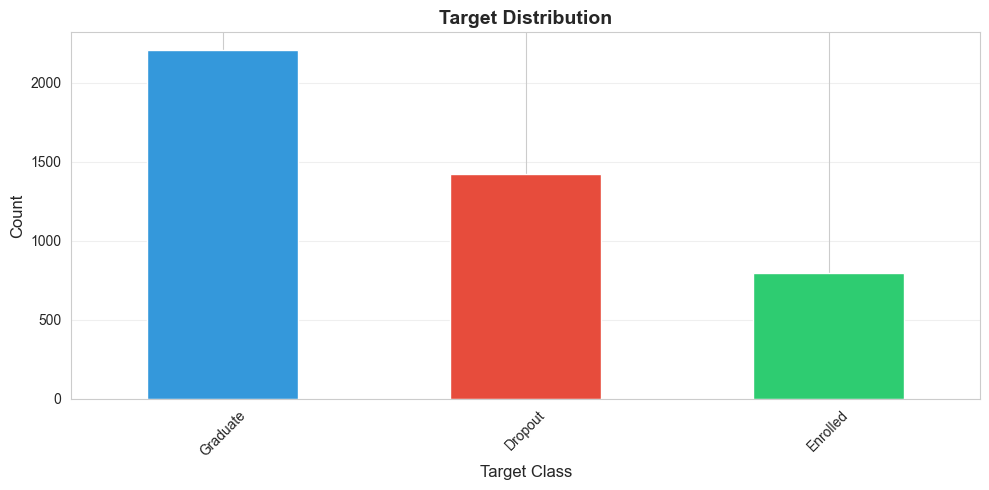

<Figure size 1400x1000 with 0 Axes>

In [9]:
# EXPLORATORY DATA ANALYSIS

# Visualize target distribution
plt.figure(figsize=(10, 5))
df['Target'].value_counts().plot(kind='bar', color=['#3498db', '#e74c3c', '#2ecc71'])
plt.title('Target Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Target Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
plt.figure(figsize=(14, 10))

# Encoded target for correlation analysis
df_encoded = df.copy()
le_temp = LabelEncoder()
df_encoded['Target_encoded'] = le_temp.fit_transform(df['Target'])

# Get numeric columns (excluding the original Target column)
numeric_cols = df_encoded.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if col != 'Target_encoded']

# Calculate correlation with encoded target
correlation_with_target = (
    df_encoded[numeric_cols]
    .corrwith(df_encoded['Target_encoded'])
    .abs()
    .sort_values(ascending=False)
)

# Get 10 features correlated with target
top_correlations = correlation_with_target.head(10).sort_values()


# 2. DATA PREPROCESSING

This step involves preparing the dataset for model training.  
Key steps include:
- Encoding categorical the target variable.
- Scaling or normalizing numerical features.
- Splitting the dataset into **training** and **testing** sets (e.g., 80/20 split).

In [10]:
# Separate features and target
X = df.drop('Target', axis=1)
y = df['Target']

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"\nTarget classes: {le.classes_}")
print(f"Encoded as: {dict(zip(le.classes_, range(len(le.classes_))))}")

# Check for any non-numeric features
non_numeric = X.select_dtypes(exclude=[np.number]).columns
if len(non_numeric) > 0:
    print(f"\nWarning: Non-numeric columns found: {non_numeric.tolist()}")
    print("These will be dropped. Consider encoding them if they're important.")
    X = X.select_dtypes(include=[np.number])

# Split the data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTraining set size: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set size: {X_test.shape[0]} samples")


# Feature scaling (important for LogReg, KNN, SVM, NB)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)




Target classes: ['Dropout' 'Enrolled' 'Graduate']
Encoded as: {'Dropout': 0, 'Enrolled': 1, 'Graduate': 2}

Training set size: 3539 samples, 36 features
Test set size: 885 samples


# 3. MODEL TRAINING AND EVALUATION

Here, we build and evaluate multiple supervised classification algorithms to predict student outcomes (Graduate, Dropout, Enrolled).

Steps:
- Train baseline models:
  - Logistic Regression
  - Decision Tree
  - Random Forest
  - KNN
  - Naive Bayes
  - SVM
- Use cross-validation to estimate generalization performance.
- Evaluate final performance on the test set using:
  - Accuracy
  - Precision, Recall, F1-score
  - Confusion Matrix
  - Classification Report
- Compare model performance to identify the most promising candidates.


In [11]:

# Dictionary to store results
results = {}

def evaluate_model(name, model, X_train, X_test, y_train, y_test, use_scaled=False):
    """Train and evaluate a model"""
    print(f"\n{'='*70}")
    print(f"Training {name}...")
    print('='*70)

    # Use scaled or original data
    X_tr = X_train_scaled if use_scaled else X_train
    X_te = X_test_scaled if use_scaled else X_test

    # Train
    model.fit(X_tr, y_train)

    # Predictions
    y_pred = model.predict(X_te)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

    # Cross-validation
    cv_scores = cross_val_score(model, X_tr, y_train, cv=5, scoring='accuracy')

    print(f"Cross-validation Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"\n Test Accuracy: {accuracy:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'y_pred': y_pred
    }

    return model


Training Logistic Regression...
Cross-validation Score: 0.7652 (+/- 0.0091)

 Test Accuracy: 0.7684

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.79      0.77      0.78       284
    Enrolled       0.52      0.33      0.41       159
    Graduate       0.80      0.93      0.86       442

    accuracy                           0.77       885
   macro avg       0.71      0.68      0.68       885
weighted avg       0.75      0.77      0.75       885


Training Random Forest...
Cross-validation Score: 0.7782 (+/- 0.0124)

 Test Accuracy: 0.7672

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.81      0.75      0.78       284
    Enrolled       0.57      0.37      0.45       159
    Graduate       0.78      0.92      0.85       442

    accuracy                           0.77       885
   macro avg       0.72      0.68      0.69       885
weighted avg       0.75      0.77      0.75      

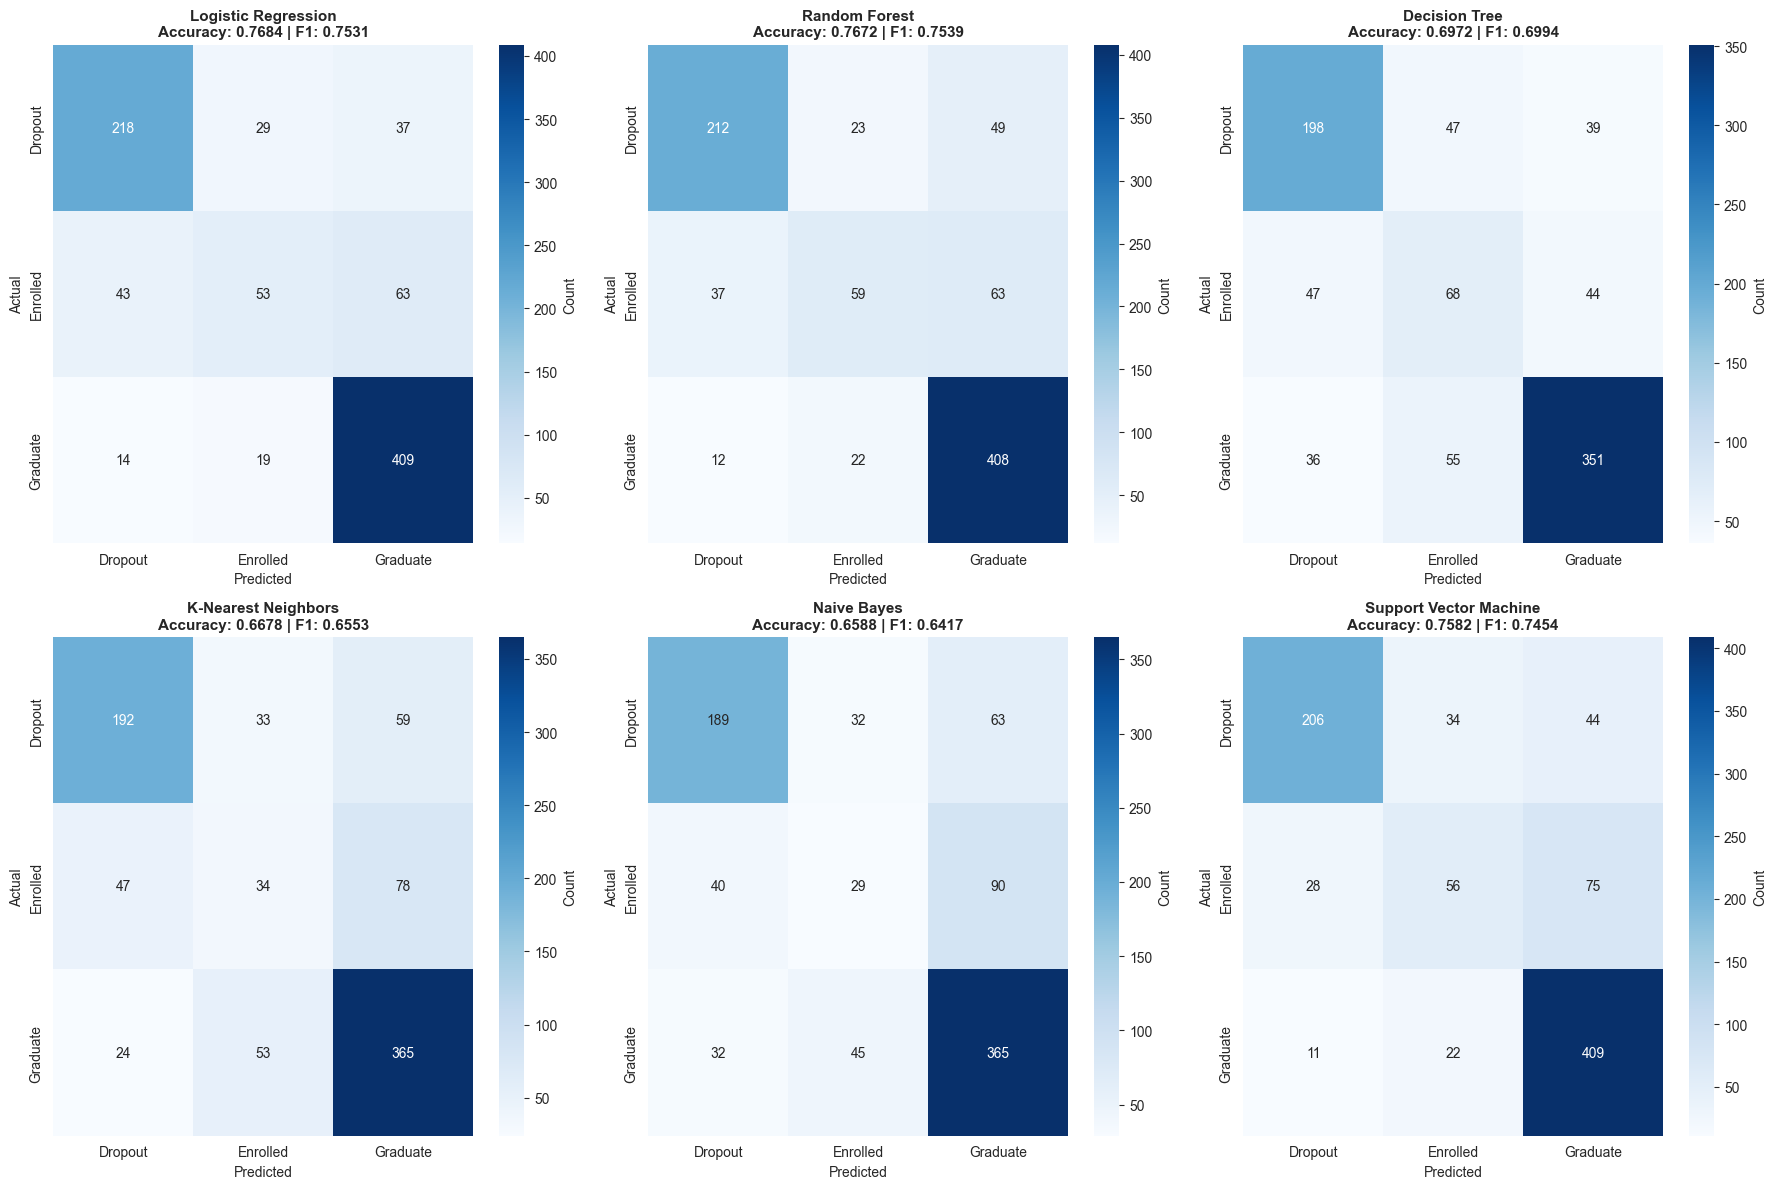

In [12]:
# Train Models : LOGISTIC REGRESSION, RANDOM FOREST,DECISION TREE, K-NEAREST NEIGHBORS, NAIVE BAYES 

# TODO 1: Train Logistic Regression Classifier
    # Create and train a Logistic Regression model
    
    # Hint: Similar to previous class i.e create an instance of the model
    # Pattern: model_name = ModelClass(parameters...)
    #          evaluate_model("Model Name", model_name, X_train, X_test, y_train, y_test, use_scaled=True)
    #
# YOUR CODE HERE:
lr_model = LogisticRegression(random_state=42)


# Logistic Regression works better with SCALED data!
evaluate_model("Logistic Regression", lr_model, X_train, X_test, y_train, y_test, use_scaled=True)





# TODO 2: Train Random Forest
    # Create and train a Random Forest mode

# YOUR CODE HERE:
rf_model = RandomForestClassifier(random_state=42)

#  Random Forest model does NOT need scaled data (use_scaled=False)
evaluate_model("Random Forest", rf_model, X_train, X_test, y_train, y_test, use_scaled=False)




# TODO 3: Train Decision Tree
    # Create and train a Decision Tree model
    #

# YOUR CODE HERE:
dt_model = DecisionTreeClassifier(random_state=42)


# Decision Trees model does NOT need scaled data (use_scaled=False)
evaluate_model("Decision Tree", dt_model, X_train, X_test, y_train, y_test, use_scaled=False)




# TODO 4: Train K-Nearest Neighbors
    # Create and train a KNN model
    #
knn_model = KNeighborsClassifier()


# YOUR CODE HERE:

# This model need scaled data (use_scaled=True) because it uses distance calculations!
evaluate_model("K-Nearest Neighbors", knn_model, X_train, X_test, y_train, y_test, use_scaled=True)


# TODO 5: Train Naive Bayes
    # Create and train a Gaussian Naive Bayes model
    # No special parameters needed
    #


# YOUR CODE HERE:
nb_model = GaussianNB()

# This model works better with scaled data since it uses probability distributions
evaluate_model("Naive Bayes", nb_model, X_train, X_test, y_train, y_test, use_scaled=True)

# TODO 6: Train Support Vector Machine
    # Create and train an SVM model
    #

# YOUR CODE HERE:
svm_model = SVC(random_state=42)

# This model NEEDS scaled data (use_scaled=True) for better performance!
evaluate_model("Support Vector Machine", svm_model, X_train, X_test, y_train, y_test, use_scaled=True)


# MODEL COMPARISON

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'Precision': [results[m]['precision'] for m in results],
    'Recall': [results[m]['recall'] for m in results],
    'F1-Score': [results[m]['f1'] for m in results],
}).sort_values('F1-Score', ascending=False)

print("\n" + "="*90)
print("MODEL COMPARISON (Sorted by F1-Score)")
print("="*90)
print(comparison_df.to_string(index=False))

# VISUALIZATIONS: Confusion Matrices

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=le.classes_, yticklabels=le.classes_, cbar_kws={'label': 'Count'})
    axes[idx].set_title(f'{name}\nAccuracy: {result["accuracy"]:.4f} | F1: {result["f1"]:.4f}',
                       fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Predicted', fontsize=10)
    axes[idx].set_ylabel('Actual', fontsize=10)

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# TODO 7: Error Analysis
    # - Examine the confusion matrices for each model.
    # - Identify the most common misclassifications (no calculations needed — just observe the largest off-diagonal values).
    # - Explain why these errors may occur.
    # - Suggest strategies to reduce these errors in future experiments.

# 4. HYPERPARAMETER TUNING

To improve model performance, we perform hyperparameter optimization for each algorithm using `GridSearchCV` technique

Steps:
- Define parameter grids for each model (e.g., max_depth for Decision Tree, n_neighbors for KNN, etc.).
- Run cross-validation to find the best parameter combination.
- Re-train models with the best parameters.
- Compare base vs tuned models using:
  - Accuracy, F1-score improvements etc..
  - Cross-validation scores

This ensures we select the most **robust and optimized model** for predicting student outcomes.

In [14]:


# Define the search space for all models
hyperparams = {
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        'params': {
            'criterion': ['gini', 'entropy'],
            'max_depth': [5, 10, 20, 30],
            'min_samples_split': [2, 5, 10, 20],
            'min_samples_leaf': [1, 2, 4]
        },
        'use_scaled': False
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'params': {
            'n_estimators': [20, 60, 80, 100, 150],
            'criterion': ['gini', 'entropy'],
            'max_depth': [5, 10, 20, None],
            'min_samples_split': [2, 5, 10],
            'bootstrap': [True, False]
        },
        'use_scaled': False
    },
    'K-Nearest Neighbors': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'metric': ['minkowski', 'euclidean', 'manhattan', 'chebyshev'],
            'p': [1, 2]
        },
        'use_scaled': True
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {
            'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
        },
        'use_scaled': True
    },
    'Support Vector Machine': {
        'model': SVC(random_state=42, class_weight='balanced'),
        'params': {
            'C': [0.1, 1, 10, 100],
            'kernel': ['rbf', 'poly', 'sigmoid'],
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
            'degree': [2, 3, 4]
        },
        'use_scaled': True
    }
}

# Store tuned results
tuned_results = {}

print("\nStarting hyperparameter tuning for all models...")
print('\n')

for model_name, config in hyperparams.items():
    print(f" Tuning: {model_name}")

    X_tune = X_train_scaled if config['use_scaled'] else X_train
    X_eval = X_test_scaled if config['use_scaled'] else X_test

    # Perform grid search
    print(f"Parameter grid: {config['params']}")
    print('\n')

    grid_search = GridSearchCV(
        config['model'],
        config['params'],
        cv=5,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=0
    )

    grid_search.fit(X_tune, y_train)

    # Get predictions
    y_pred_tuned = grid_search.predict(X_eval)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_tuned)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_tuned, average='weighted')

    # Store results
    tuned_results[model_name] = {
        'best_model': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'best_cv_score': grid_search.best_score_,
        'test_accuracy': accuracy,
        'test_precision': precision,
        'test_recall': recall,
        'test_f1': f1,
        'y_pred': y_pred_tuned
    }


Starting hyperparameter tuning for all models...


 Tuning: Decision Tree
Parameter grid: {'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 20, 30], 'min_samples_split': [2, 5, 10, 20], 'min_samples_leaf': [1, 2, 4]}


 Tuning: Random Forest
Parameter grid: {'n_estimators': [20, 60, 80, 100, 150], 'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 20, None], 'min_samples_split': [2, 5, 10], 'bootstrap': [True, False]}


 Tuning: K-Nearest Neighbors
Parameter grid: {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance'], 'metric': ['minkowski', 'euclidean', 'manhattan', 'chebyshev'], 'p': [1, 2]}


 Tuning: Naive Bayes
Parameter grid: {'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]}


 Tuning: Support Vector Machine
Parameter grid: {'C': [0.1, 1, 10, 100], 'kernel': ['rbf', 'poly', 'sigmoid'], 'gamma': ['scale', 'auto', 0.001, 0.01, 0.1], 'degree': [2, 3, 4]}




In [15]:
# COMPARISON: BASE vs TUNED MODELS
# Fetch keys from your result dicts
def _get(d, *keys, default=float("nan")):
    cur = d
    for k in keys:
        if cur is None or k not in cur:
            return default
        cur = cur[k]
    return cur

models_in_tuned = list(tuned_results.keys())

tuned_comparison = pd.DataFrame({
    "Model": models_in_tuned,
    "Base Accuracy": [ _get(results, m, "accuracy") for m in models_in_tuned ],
    "Tuned Accuracy": [ _get(tuned_results, m, "test_accuracy") for m in models_in_tuned ],
    "Base F1-Score": [ _get(results, m, "f1") for m in models_in_tuned ],
    "Tuned F1-Score": [ _get(tuned_results, m, "test_f1") for m in models_in_tuned ],
    "CV Score": [ _get(tuned_results, m, "best_cv_score") for m in models_in_tuned ],
})


tuned_comparison = tuned_comparison.sort_values("Tuned F1-Score", ascending=False).reset_index(drop=True)

print("\n BASE vs TUNED MODEL COMPARISON")
print("="*90)
print(tuned_comparison.to_string(index=False))

# Identify best tuned model
best_tuned = tuned_comparison.iloc[0]
best_model_name = best_tuned["Model"]
print(f"\n Best Tuned Model: {best_model_name}")
print(f"   Tuned Accuracy: {best_tuned['Tuned Accuracy']:.4f}")
print(f"   Tuned F1-Score: {best_tuned['Tuned F1-Score']:.4f}")

# Print best parameters for top model
print(f"\n Best Parameters for {best_model_name}:")
best_params = _get(tuned_results, best_model_name, "best_params", default={})
if isinstance(best_params, dict) and best_params:
    for param, value in best_params.items():
        print(f"   {param}: {value}")
else:
    print("   (No param dict found)")

# "best params" table for all models
best_params_rows = []
for m in models_in_tuned:
    best_params_rows.append({
        "model": m,
        "best_params": _get(tuned_results, m, "best_params", default={}),
        "best_score": _get(tuned_results, m, "best_cv_score")
    })
best_params_df = pd.DataFrame(best_params_rows)
print("\nBest Params Summary")
print(best_params_df.to_string(index=False))




 BASE vs TUNED MODEL COMPARISON
                 Model  Base Accuracy  Tuned Accuracy  Base F1-Score  Tuned F1-Score  CV Score
         Random Forest       0.767232        0.766102       0.753903        0.768117  0.775298
Support Vector Machine       0.758192        0.726554       0.745353        0.739014  0.755884
         Decision Tree       0.697175        0.699435       0.699416        0.713227  0.729651
   K-Nearest Neighbors       0.667797        0.700565       0.655282        0.685770  0.706272
           Naive Bayes       0.658757        0.658757       0.641673        0.641673  0.654339

 Best Tuned Model: Random Forest
   Tuned Accuracy: 0.7661
   Tuned F1-Score: 0.7681

 Best Parameters for Random Forest:
   bootstrap: False
   criterion: gini
   max_depth: 20
   min_samples_split: 10
   n_estimators: 60

Best Params Summary
                 model                                                                                             best_params  best_score
         Deci